## 6.10 Homework

The goal of this homework is to create a tree-based regression model for prediction apartment prices (column `'price'`).

In this homework we'll again use the New York City Airbnb Open Data dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv)
or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv)
if you don't want to sign up to Kaggle.

Let's load the data:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv

--2021-10-20 11:45:56--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7077973 (6.8M) [text/plain]
Saving to: ‘AB_NYC_2019.csv.3’

AB_NYC_2019.csv.3   100%[===================>]   6.75M  --.-KB/s    in 0.1s    

2021-10-20 11:45:56 (46.0 MB/s) - ‘AB_NYC_2019.csv.3’ saved [7077973/7077973]



In [3]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df = pd.read_csv('AB_NYC_2019.csv', usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)

* Apply the log tranform to `price`
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1

In [4]:
df['price_log'] = np.log1p(df.price)
price = df['price']
df.drop('price', axis = 1, inplace = True)

In [5]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [6]:
df_train = df_train.reset_index(drop=True)
y_train = df_train['price_log']
df_val = df_val.reset_index(drop=True)
y_val = df_val['price_log']
df_test = df_test.reset_index(drop=True)
y_test = df_test['price_log']

del df_train['price_log']
del df_val['price_log']
del df_test['price_log']

Now, use `DictVectorizer` to turn train and validation into matrices:

In [7]:
train_dicts = df_train.to_dict(orient = 'records')
val_dicts = df_val.to_dict(orient = 'records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

## Question 1

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`

In [8]:
dt = DecisionTreeRegressor(max_depth = 1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=1,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

Which feature is used for splitting the data?

* `room_type`
* `neighbourhood_group`
* `number_of_reviews`
* `reviews_per_month`

In [9]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

What's the RMSE of this model on validation?

* 0.059
* 0.259
* 0.459
* 0.659

In [12]:
rf = RandomForestRegressor(n_estimators = 10, random_state = 1, n_jobs = -1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
rms = mean_squared_error(y_val, y_pred, squared = False)
rms

0.460888788095762

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset

In [13]:
n_estimators = list(np.arange(10, 201, 10))

In [16]:
scores = []
for n_estimator in n_estimators:
  rf = RandomForestRegressor(n_estimators=n_estimator, random_state=1, n_jobs = -1)
  rf.fit(X_train, y_train)
  pred = rf.predict(X_val)
  scores.append(mean_squared_error(y_val, pred, squared = False))

scores

[0.460888788095762,
 0.44744055425901735,
 0.44440015830200136,
 0.44281711871165336,
 0.44176815762157207,
 0.44125165338475053,
 0.44064455072014125,
 0.440740830263047,
 0.4402749020311618,
 0.4397631903425602,
 0.4393128261208466,
 0.43912990819267467,
 0.4392796575512702,
 0.4391514983746916,
 0.43902892484355854,
 0.4388423640549406,
 0.4387460509023033,
 0.4388528948224223,
 0.4387907435385231,
 0.4387871286025359]

After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- 120

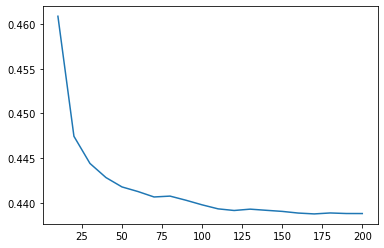

In [17]:
import matplotlib.pyplot as plt
plt.plot(n_estimators, scores)

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [27]:
different_depth = {}

max_depth = [10, 15, 20, 25]

for depth in max_depth:
  rmse = []
  for n_estimator in list(np.arange(10, 201, 10)):
    rf = RandomForestRegressor(n_estimators=n_estimator, random_state=1, n_jobs = -1, max_depth=depth)
    rf.fit(X_train, y_train)
    pred = rf.predict(X_val)
    rmse.append((n_estimator, mean_squared_error(y_val, pred, squared = False)))
    different_depth[depth] = rmse

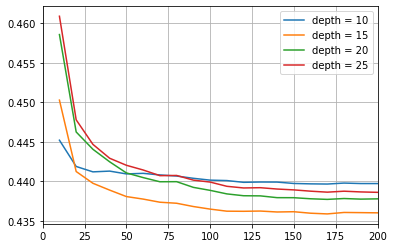

In [28]:
for depth, rmses in different_depth.items():
  plt.plot(*zip(*rmses), label='depth = %d' % depth)
  plt.xlim(0, 200)
plt.grid()
plt.legend()
plt.show()

What's the best `max_depth`:

* 10
* 15
* 20
* 25

Bonus question (not graded):

Will the answer be different if we change the seed for the model?

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [29]:
rf = RandomForestRegressor(n_estimators = 10, max_depth = 20, random_state = 1, n_jobs = -1)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=-1, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

What's the most important feature? 

* `neighbourhood_group=Manhattan`
* `room_type=Entire home/apt`	
* `longitude`
* `latitude`

In [30]:
list(zip(dv.get_feature_names(), rf.feature_importances_))

[('availability_365', 0.07651608462923112),
 ('calculated_host_listings_count', 0.030906352520589986),
 ('latitude', 0.15205397490899036),
 ('longitude', 0.15321933669623872),
 ('minimum_nights', 0.0536452299566982),
 ('neighbourhood_group=Bronx', 0.0002838225491492307),
 ('neighbourhood_group=Brooklyn', 0.0011661162111558155),
 ('neighbourhood_group=Manhattan', 0.03401674428986242),
 ('neighbourhood_group=Queens', 0.0011532423357895512),
 ('neighbourhood_group=Staten Island', 0.00011802695206485345),
 ('number_of_reviews', 0.0435248857335957),
 ('reviews_per_month', 0.05243793489874994),
 ('room_type=Entire home/apt', 0.3918968371926611),
 ('room_type=Private room', 0.004520617592045859),
 ('room_type=Shared room', 0.004540793533177226)]

In [31]:
importances = list(zip(dv.get_feature_names(), rf.feature_importances_))

df_importance = pd.DataFrame(importances, columns=['feature', 'gain'])
df_importance = df_importance.sort_values(by='gain', ascending=False)
df_importance

,feature,gain
12,room_type=Entire home/apt,0.391897
3,longitude,0.153219
2,latitude,0.152054
0,availability_365,0.076516
4,minimum_nights,0.053645
11,reviews_per_month,0.052438
10,number_of_reviews,0.043525
7,neighbourhood_group=Manhattan,0.034017
1,calculated_host_listings_count,0.030906
14,room_type=Shared room,0.004541


## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

In [50]:
import xgboost as xgb
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [51]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [52]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

In [55]:
%%capture output
# capture instruction that saves the result to output 
model = xgb.train(xgb_params, dtrain,
                  num_boost_round=100,
                  evals=watchlist, verbose_eval=10)

In [56]:
def parse_xgb_output(output):
    tree = []
    p_train = []
    p_val = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        tree.append(it)
        p_train.append(train)
        p_val.append(val)

    return tree, p_train, p_val
#enddef
tree, p_train, p_val = parse_xgb_output(output)

In [57]:
print('Best performance ', min(zip(p_val, tree)))

Best performance  (0.432784, 70)


Now change `eta` first to `0.1` and then to `0.01`

In [58]:
%%capture output_010
# capture instruction that saves the result to output 
xgb_params['eta'] = 0.1
model = xgb.train(xgb_params, dtrain,
                  num_boost_round=100,
                  evals=watchlist, verbose_eval=10)

In [59]:
tree, _, p_val = parse_xgb_output(output_010)
print(f'Eta={xgb_params["eta"]} : Best performance ', min(zip(p_val, tree)))

Eta=0.1 : Best performance  (0.432873, 99)


In [60]:
%%capture output_001
# capture instruction that saves the result to output 
xgb_params['eta'] = 0.01
model = xgb.train(xgb_params, dtrain,
                  num_boost_round=100,
                  evals=watchlist, verbose_eval=10)

In [61]:
tree, _, p_val = parse_xgb_output(output_001)
print(f'Eta={xgb_params["eta"]} : Best performance ', min(zip(p_val, tree)))

Eta=0.01 : Best performance  (1.63049, 99)


Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* 0.01

## Submit the results


Submit your results here: https://forms.gle/wQgFkYE6CtdDed4w8

It's possible that your answers won't match exactly. If it's the case, select the closest one.


## Deadline


The deadline for submitting is 20 October 2021, 17:00 CET (Wednesday). After that, the form will be closed.

